## Set up

In [1]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import keras as tfk
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-12-14 09:20:12.343578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 09:20:12.343930: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 09:20:12.346950: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 09:20:12.379893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-14 09:20:13.170753: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
VALIDATION_SPLIT = 0.2
SEED = 42
RNG = np.random.default_rng(SEED)

In [3]:
RESULTS_DIR = Path().absolute().parent / "results"
BIG_ROCK_EXPERIMENT = "131"
GENERIC_EXPERIMENT = "130"

BIG_ROCK_DIR = RESULTS_DIR / BIG_ROCK_EXPERIMENT
GENERIC_DIR = RESULTS_DIR / GENERIC_EXPERIMENT

print(BIG_ROCK_DIR)
print(GENERIC_DIR)

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-2/results/131
/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-2/results/130


In [4]:
CLASS_MAP = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}

In [5]:
def mean_iou(y_true, y_pred):
    metric = tfk.metrics.MeanIoU(
        num_classes=5, ignore_class=0, sparse_y_pred=True, sparse_y_true=True
    )
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

### Load data

In [6]:
DATA_ROOT = Path("/kaggle/input/an2dl-hw2-clean")
if not DATA_ROOT.exists():
    DATA_ROOT = Path().absolute().parent / "data" / "clean"

with np.load(DATA_ROOT / "train.npz") as data:
    original_x_train = data["x"]
    original_y_train = data["y"]
with np.load(DATA_ROOT / "test.npz") as data:
    original_x_test = data["x"]

original_x_train = original_x_train[..., np.newaxis] / 255.0
original_y_train = original_y_train[..., np.newaxis]
original_x_test = original_x_test[..., np.newaxis] / 255.0

X_train = original_x_train
y_train = original_y_train
X_test = original_x_test

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SPLIT, random_state=SEED
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2004, 64, 128, 1) (2004, 64, 128, 1)
(501, 64, 128, 1) (501, 64, 128, 1)


### Load models

#### Big Rock

In [8]:
big_rock_model: tfk.Model = tfk.saving.load_model(
    BIG_ROCK_DIR / "model.keras",
    custom_objects={"loss": None},
)
big_rock_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 64, 128,   │          0 │ input_layer_1[0]… │
│ (GaussianNoise)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 128,   │        640 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_25[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 128,   │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_26[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 128,   │        128 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 128,   │          0 │ activation_15[0]… │
│                     │ 64)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 64,    │          0 │ add_10[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_28[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 64,    │    147,584 │ activation_16[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_29[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 64,    │          0 │ layer_normalizat

 Total params: 22,079,240 (84.23 MB)

 Trainable params: 7,359,746 (28.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,719,494 (56.15 MB)

#### Combined

In [9]:
combined_model: tfk.Model = tfk.saving.load_model(
    GENERIC_DIR / "model.keras",
    custom_objects={"loss": None},
)
combined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 64, 128,   │          0 │ input_layer_1[0]… │
│ (GaussianNoise)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 128,   │        640 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_25[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 128,   │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_26[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 128,   │        128 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 128,   │          0 │ activation_15[0]… │
│                     │ 64)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 64,    │          0 │ add_10[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_28[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 64,    │    147,584 │ activation_16[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_29[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 64,    │          0 │ layer_normalizat

 Total params: 22,079,630 (84.23 MB)

 Trainable params: 7,359,876 (28.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,719,754 (56.15 MB)

## Compute predictions

In [10]:
combined_val_predictions: np.ndarray = combined_model.predict(X_val)
big_rock_val_predictions: np.ndarray = big_rock_model.predict(X_val)

print(combined_val_predictions.shape, big_rock_val_predictions.shape)

I0000 00:00:1734164417.809410   20714 service.cc:145] XLA service 0x7d8638015da0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734164417.809459   20714 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-12-14 09:20:17.832129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734164418.520152   20714 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 719ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 670ms/step
(501, 64, 128, 4) (501, 64, 128, 2)


In [11]:
combined_val_argmax: np.ndarray = np.argmax(combined_val_predictions, axis=-1)
print(combined_val_argmax.shape)
print(np.unique(combined_val_argmax, return_counts=True))

(501, 64, 128)
(array([0, 1, 2, 3]), array([  20556, 1819313, 1250822, 1013501]))


We need to convert back from (0, 1) labels used to train Big Rock model to actual labels (0 for background and 4 for big rock).

In [12]:
big_rock_val_argmax: np.ndarray = np.argmax(big_rock_val_predictions, axis=-1)
big_rock_val_argmax = np.where(big_rock_val_argmax == 1, 4, big_rock_val_argmax)
print(big_rock_val_argmax.shape)
print(np.unique(big_rock_val_argmax, return_counts=True))

(501, 64, 128)
(array([0, 4]), array([3824506,  279686]))


### Test Time Augmentation

#### Experiment with different augmentation options

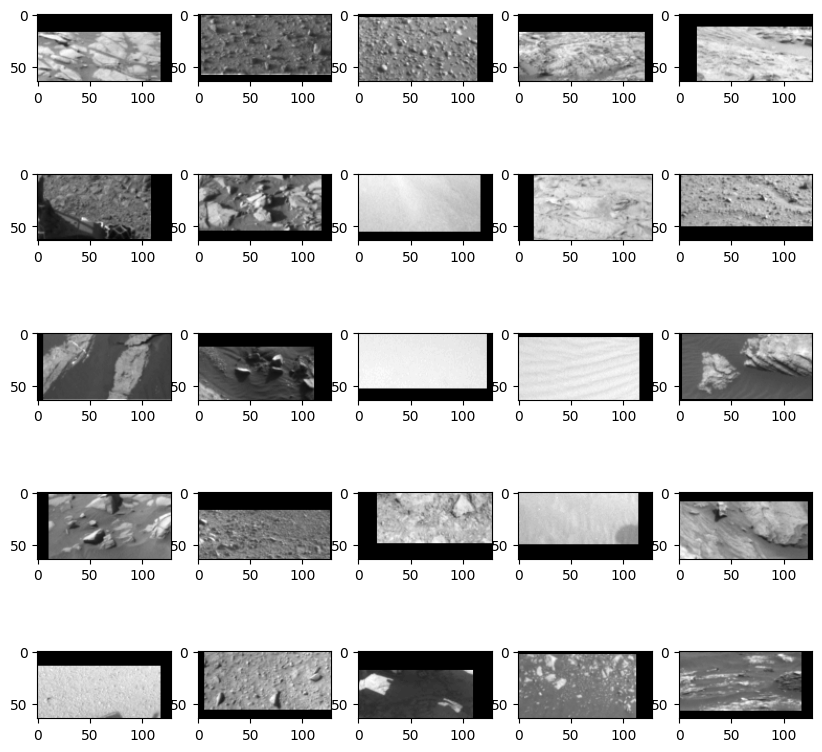

In [13]:
_, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for ax, x in zip(axes.flat, np.pad(X_val, ((0, 0), (20, 20), (20, 20), (0, 0)))):
    i = RNG.integers(0, x.shape[0] - 64)
    j = RNG.integers(0, x.shape[1] - 128)
    translated_x = x[i : i + 64, j : j + 128]
    ax.imshow(translated_x, cmap="gray")

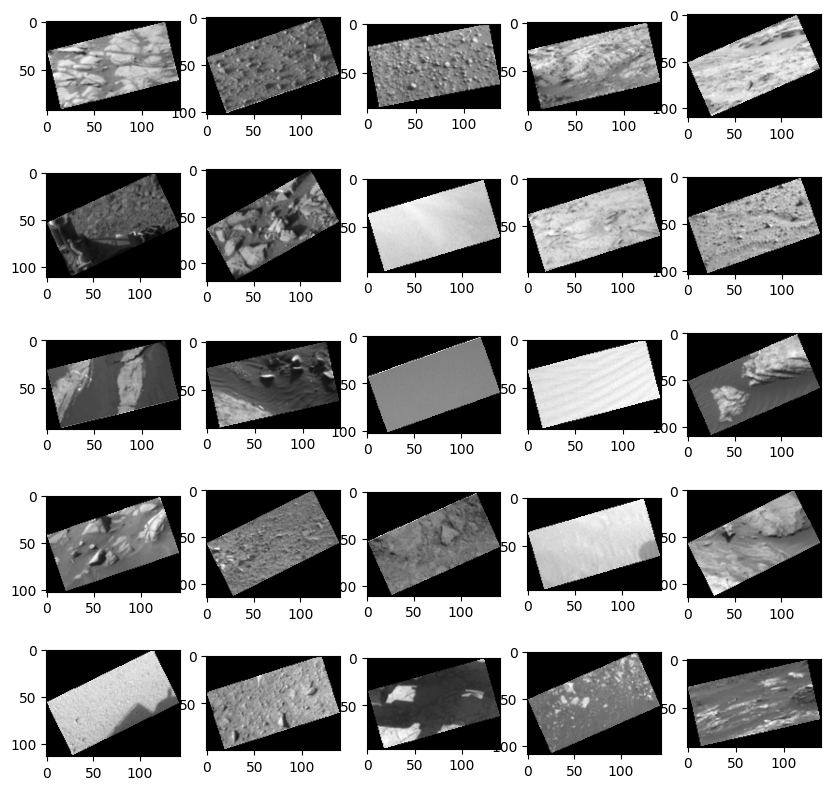

In [14]:
import scipy.ndimage

_, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for ax, x in zip(axes.flat, X_val):
    ax.imshow(scipy.ndimage.rotate(x, RNG.uniform(10, 30)), cmap="gray")

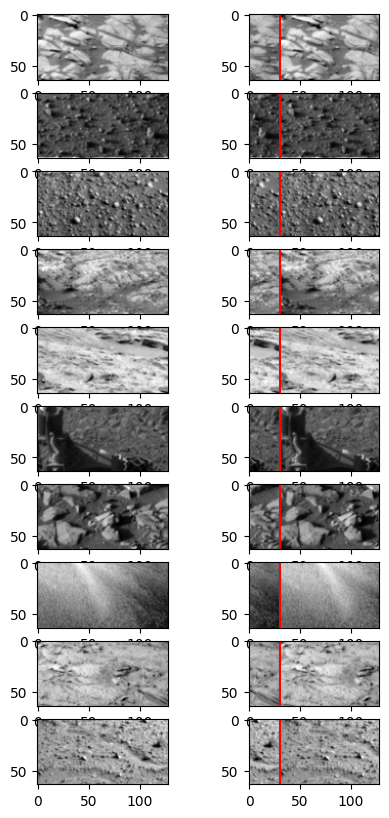

In [15]:
_, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 10))
for ax, x, rolled_x in zip(axes, X_val, np.roll(X_val, (0, 30), axis=(1, 2))):
    ax[0].imshow(x, cmap="gray")
    ax[1].imshow(rolled_x, cmap="gray")
    ax[1].axvline(30, c="r")

#### Compute augmentations

In [16]:
def augment(x, y) -> tuple[np.ndarray, np.ndarray, dict]:
    angle = RNG.uniform(-20, 20)
    mask = scipy.ndimage.rotate(np.ones_like(x), angle, reshape=False)
    augmented_x = scipy.ndimage.rotate(x, angle, reshape=False)
    augmented_y = scipy.ndimage.rotate(y, angle, reshape=False)
    return augmented_x, augmented_y, angle, mask


def reverse_augment(x, y, angle) -> tuple[np.ndarray, np.ndarray]:
    return (
        scipy.ndimage.rotate(x, -angle, reshape=False),
        scipy.ndimage.rotate(y, -angle, reshape=False),
    )

In [17]:
AUGMENTATION_FACTOR = 5

augmentation_angles = []
augmentation_mask_list = []
X_augmented_list = []
y_augmented_list = []
for x, y in zip(X_val, y_val):
    for _ in range(AUGMENTATION_FACTOR):
        mask = np.ones_like(x)
        angle = RNG.uniform(-20, 20)
        augmentation_angles.append(angle)
        augmentation_mask_list.append(
            scipy.ndimage.rotate(mask, angle, reshape=False)[np.newaxis, ...]
        )
        X_augmented_list.append(
            scipy.ndimage.rotate(x, angle, reshape=False)[np.newaxis, ...]
        )
        y_augmented_list.append(
            scipy.ndimage.rotate(y, angle, reshape=False)[np.newaxis, ...]
        )

augmentation_masks = np.concatenate(augmentation_mask_list)
X_augmented = np.concatenate(X_augmented_list)
y_augmented = np.concatenate(y_augmented_list)

print(X_augmented.shape, y_augmented.shape)

(2505, 64, 128, 1) (2505, 64, 128, 1)


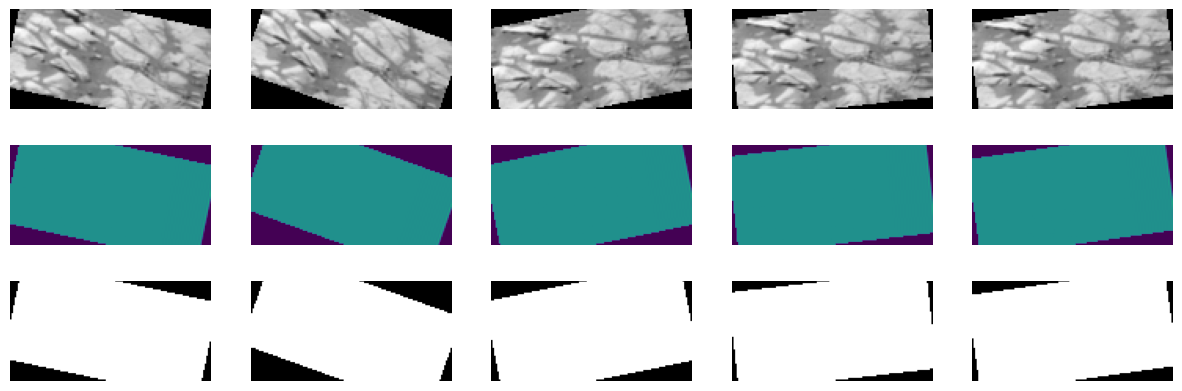

In [18]:
_, axes = plt.subplots(ncols=AUGMENTATION_FACTOR, nrows=3, figsize=(15, 5))
for ax in axes.flat:
    ax.set_axis_off()
for ax, mask, x, y in zip(
    axes.T.reshape((-1, 3)), augmentation_masks, X_augmented_list, y_augmented_list
):
    ax[0].imshow(x.squeeze(), cmap="grey")
    ax[1].imshow(y.squeeze(), cmap="viridis", vmin=0, vmax=4)
    ax[2].imshow(mask.squeeze(), cmap="grey")

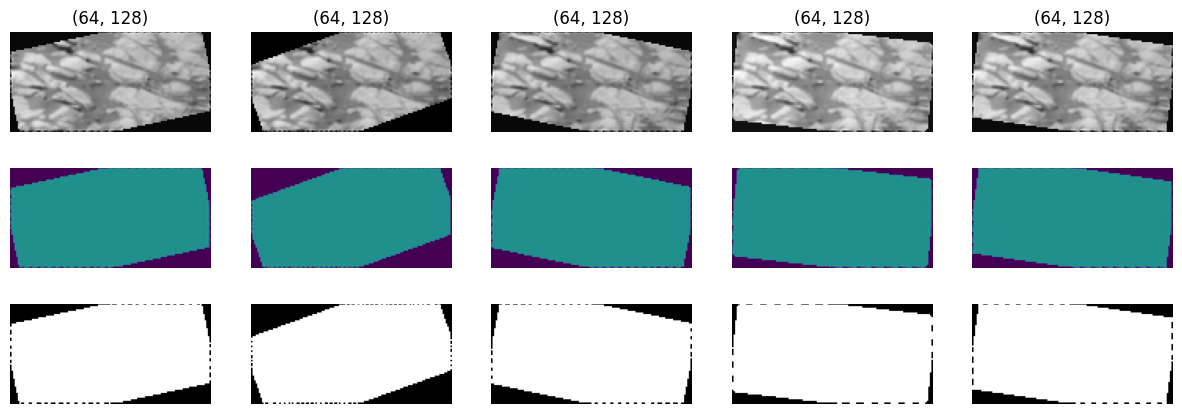

In [19]:
_, axes = plt.subplots(ncols=AUGMENTATION_FACTOR, nrows=3, figsize=(15, 5))
for ax in axes.flat:
    ax.set_axis_off()
for ax, angle, mask, x, y in zip(
    axes.T.reshape((-1, 3)),
    augmentation_angles,
    augmentation_masks,
    X_augmented_list,
    y_augmented_list,
):
    rotated_x = scipy.ndimage.rotate(x.squeeze(), -angle, reshape=False)
    ax[0].imshow(rotated_x, cmap="gray")
    ax[0].set_title(rotated_x.shape)
    ax[1].imshow(
        scipy.ndimage.rotate(y.squeeze(), -angle, reshape=False),
        cmap="viridis",
        vmin=0,
        vmax=4,
    )
    ax[2].imshow(
        scipy.ndimage.rotate(mask.squeeze(), -angle, reshape=False) > 0.5, cmap="gray"
    )

In [20]:
big_rock_augmented_predictions: np.ndarray = big_rock_model.predict(X_augmented)
big_rock_augmented_predictions.shape

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 656ms/step


(2505, 64, 128, 2)

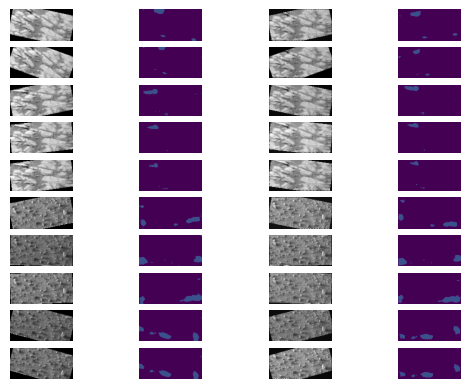

In [21]:
_, axes = plt.subplots(nrows=10, ncols=4)
for ax in axes.flat:
    ax.set_axis_off()
for ax, x, y, angle in zip(
    axes, X_augmented, big_rock_augmented_predictions, augmentation_angles
):
    reverse_x, reverse_y = reverse_augment(x, y, angle)
    ax[0].imshow(x, cmap="grey")
    ax[1].imshow(np.argmax(y, axis=-1), cmap="viridis", vmin=0, vmax=4)
    ax[2].imshow(reverse_x, cmap="grey")
    ax[3].imshow(np.argmax(reverse_y, axis=-1), cmap="viridis", vmin=0, vmax=4)

In [22]:
big_rock_augmented_argmax = np.argmax(big_rock_augmented_predictions, axis=-1)
big_rock_augmented_argmax = np.where(
    big_rock_augmented_argmax == 1, 4, big_rock_augmented_argmax
)
print(big_rock_augmented_argmax.shape)
print(np.unique(big_rock_augmented_argmax, return_counts=True))

(2505, 64, 128)
(array([0, 4]), array([19164288,  1356672]))


In [23]:
number_augmented_samples = big_rock_augmented_predictions.shape[0]
big_rock_augmented_batch_predictions_list = []
for i in range(0, number_augmented_samples, AUGMENTATION_FACTOR):
    batch_prediction_list = []
    for j in range(AUGMENTATION_FACTOR):
        mask, prediction = reverse_augment(
            augmentation_masks[i + j],
            big_rock_augmented_predictions[i + j],
            augmentation_angles[i + j],
        )
        mask = mask > 0.5
        batch_prediction_list.append(prediction * mask)
    batch_predictions = np.stack(batch_prediction_list)
    batch_prediction_mean = np.mean(batch_predictions, axis=0)
    big_rock_augmented_batch_predictions_list.append(batch_prediction_mean)

big_rock_augmented_batch_predictions = np.stack(
    big_rock_augmented_batch_predictions_list
)
print(big_rock_augmented_batch_predictions.shape)

(501, 64, 128, 2)


In [24]:
big_rock_augmented_batch_argmax = np.argmax(
    big_rock_augmented_batch_predictions, axis=-1
)
big_rock_augmented_batch_argmax = np.where(
    big_rock_augmented_batch_argmax == 1, 4, big_rock_augmented_batch_argmax
)
print(big_rock_augmented_batch_argmax.shape)
print(np.unique(big_rock_augmented_batch_argmax, return_counts=True))

(501, 64, 128)
(array([0, 4]), array([3828043,  276149]))


## Analyse individual predictions

In [25]:
def plot_predictions(x, y, combined, big_rock, n=10):
    _, axes = plt.subplots(nrows=n, ncols=4, figsize=(10, 2 * n))
    for ax in axes.flat:
        ax.set_axis_off()
    for image, mask, combined_mask, big_rock_mask, ax in zip(
        x, y, combined, big_rock, axes
    ):
        ax[0].set_title("Image")
        ax[0].imshow(image, cmap="gray")
        ax[1].set_title("Mask")
        ax[1].imshow(mask, cmap="viridis", vmin=0, vmax=4)
        ax[2].set_title("Combined Mask")
        ax[2].imshow(combined_mask, cmap="viridis", vmin=0, vmax=4)
        ax[3].set_title("Big Rock Mask")
        ax[3].imshow(big_rock_mask, cmap="viridis", vmin=0, vmax=4)

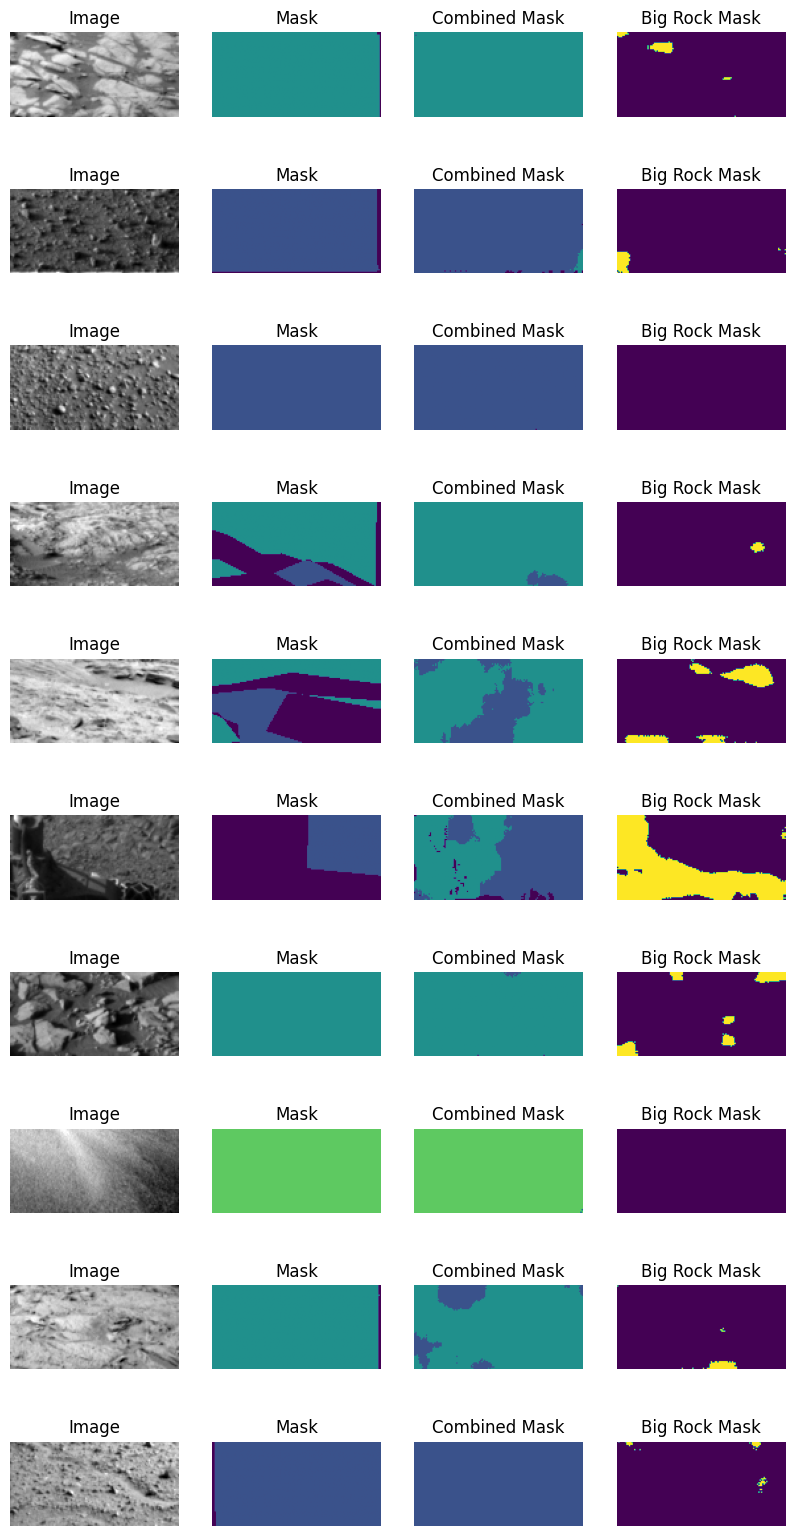

In [26]:
plot_predictions(X_val, y_val, combined_val_argmax, big_rock_val_argmax)

In [27]:
big_rock_mask: np.ndarray = (y_val == 4).any(axis=(1, 2)).ravel()
big_rock_mask.mean()

0.013972055888223553

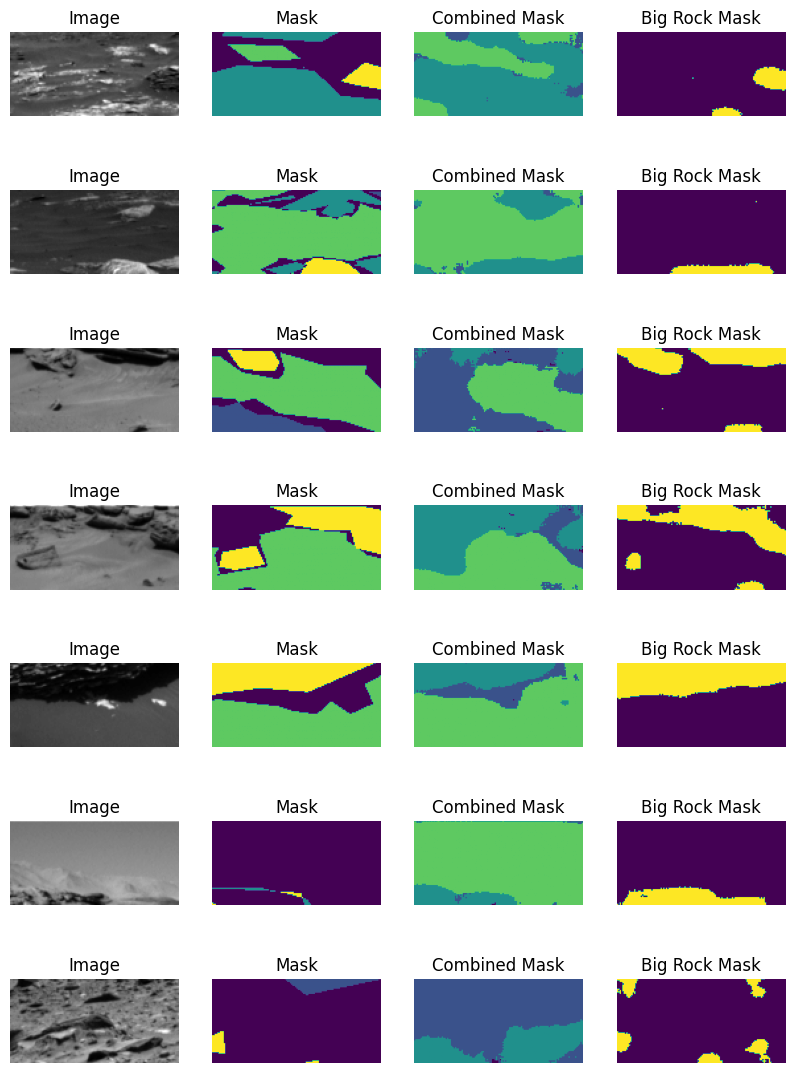

In [28]:
plot_predictions(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    combined_val_argmax[big_rock_mask],
    big_rock_val_argmax[big_rock_mask],
    n=big_rock_mask.sum(),
)

### Probabilities

In [29]:
big_rock_probas = big_rock_val_predictions[:, :, :, 1]
big_rock_probas = big_rock_probas[..., np.newaxis]
big_rock_probas.shape

(501, 64, 128, 1)

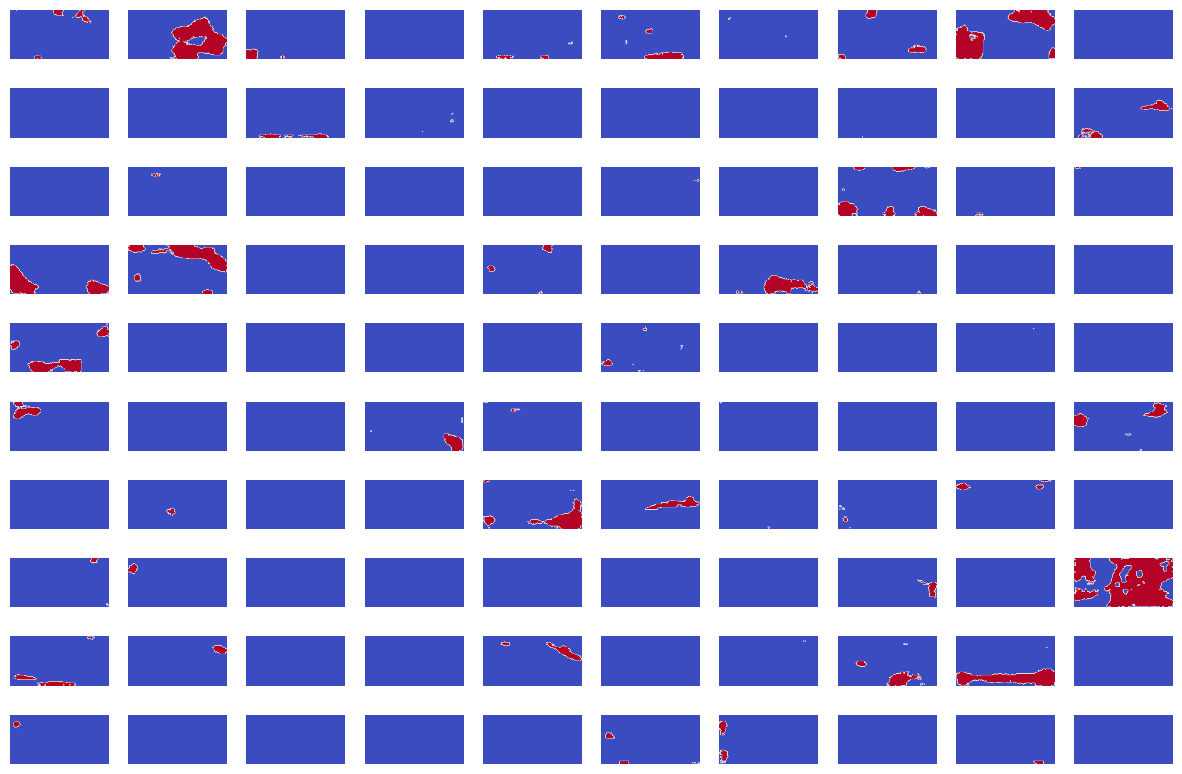

In [30]:
THRESHOLD = 0.99

_, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 10))
for big_rock_proba, ax in zip(RNG.permutation(big_rock_probas), axes.flat):
    ax.set_axis_off()
    ax.imshow(np.where(big_rock_proba > THRESHOLD, big_rock_proba, 0), cmap="coolwarm")

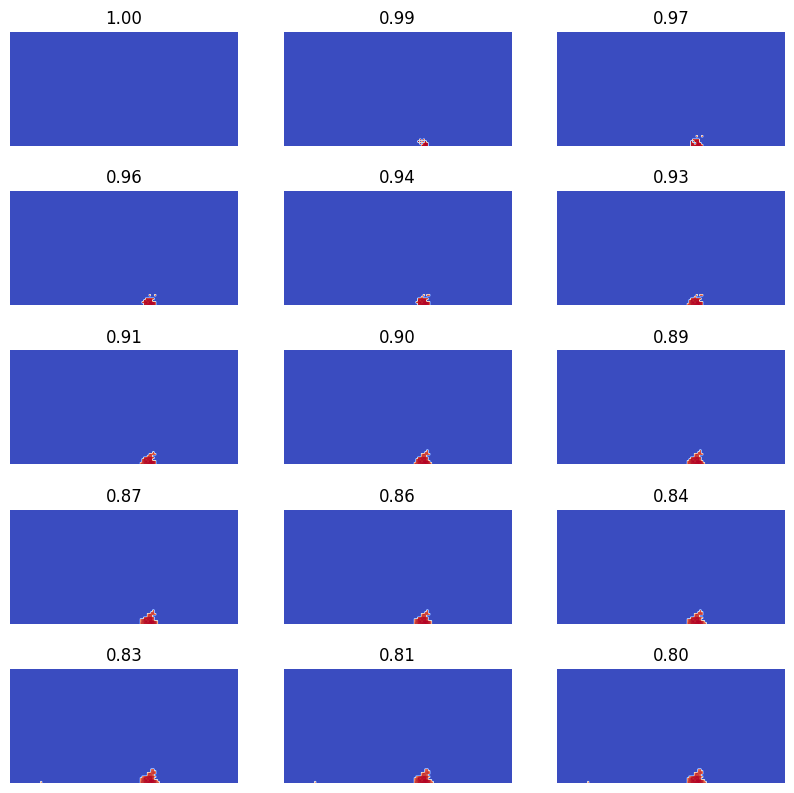

In [31]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
big_rock_proba_sample = RNG.choice(big_rock_probas)
for threshold, ax in zip(np.linspace(1, 0.8, axes.size), axes.flat):
    ax.set_axis_off()
    ax.set_title(f"{threshold:.2f}")
    ax.imshow(
        np.where(big_rock_proba_sample > threshold, big_rock_proba_sample, 0),
        cmap="coolwarm",
    )

In [32]:
def plot_probabilities(
    x, y, combined, big_rock, n=10, combined_threshold=0.99, big_rock_threshold=0.99
):
    _, axes = plt.subplots(nrows=n, ncols=7, figsize=(20, 2 * n))
    for ax in axes.flat:
        ax.set_axis_off()

    combined = np.where(combined > combined_threshold, combined, 0.0)
    big_rock = np.where(big_rock > big_rock_threshold, big_rock, 0.0)

    for image, mask, combined_mask, big_rock_mask, row_axes in zip(
        x, y, combined, big_rock, axes
    ):
        for i, ax in enumerate(row_axes[:4]):
            ax.set_title(CLASS_MAP[i])
            ax.imshow(combined_mask[:, :, i], cmap="coolwarm")
        row_axes[4].set_title(CLASS_MAP[4])
        row_axes[4].imshow(big_rock_mask, cmap="coolwarm")
        row_axes[5].set_title("Mask")
        row_axes[5].imshow(mask, cmap="viridis", vmin=0, vmax=4)
        row_axes[6].set_title("Image")
        row_axes[6].imshow(image, cmap="gray")

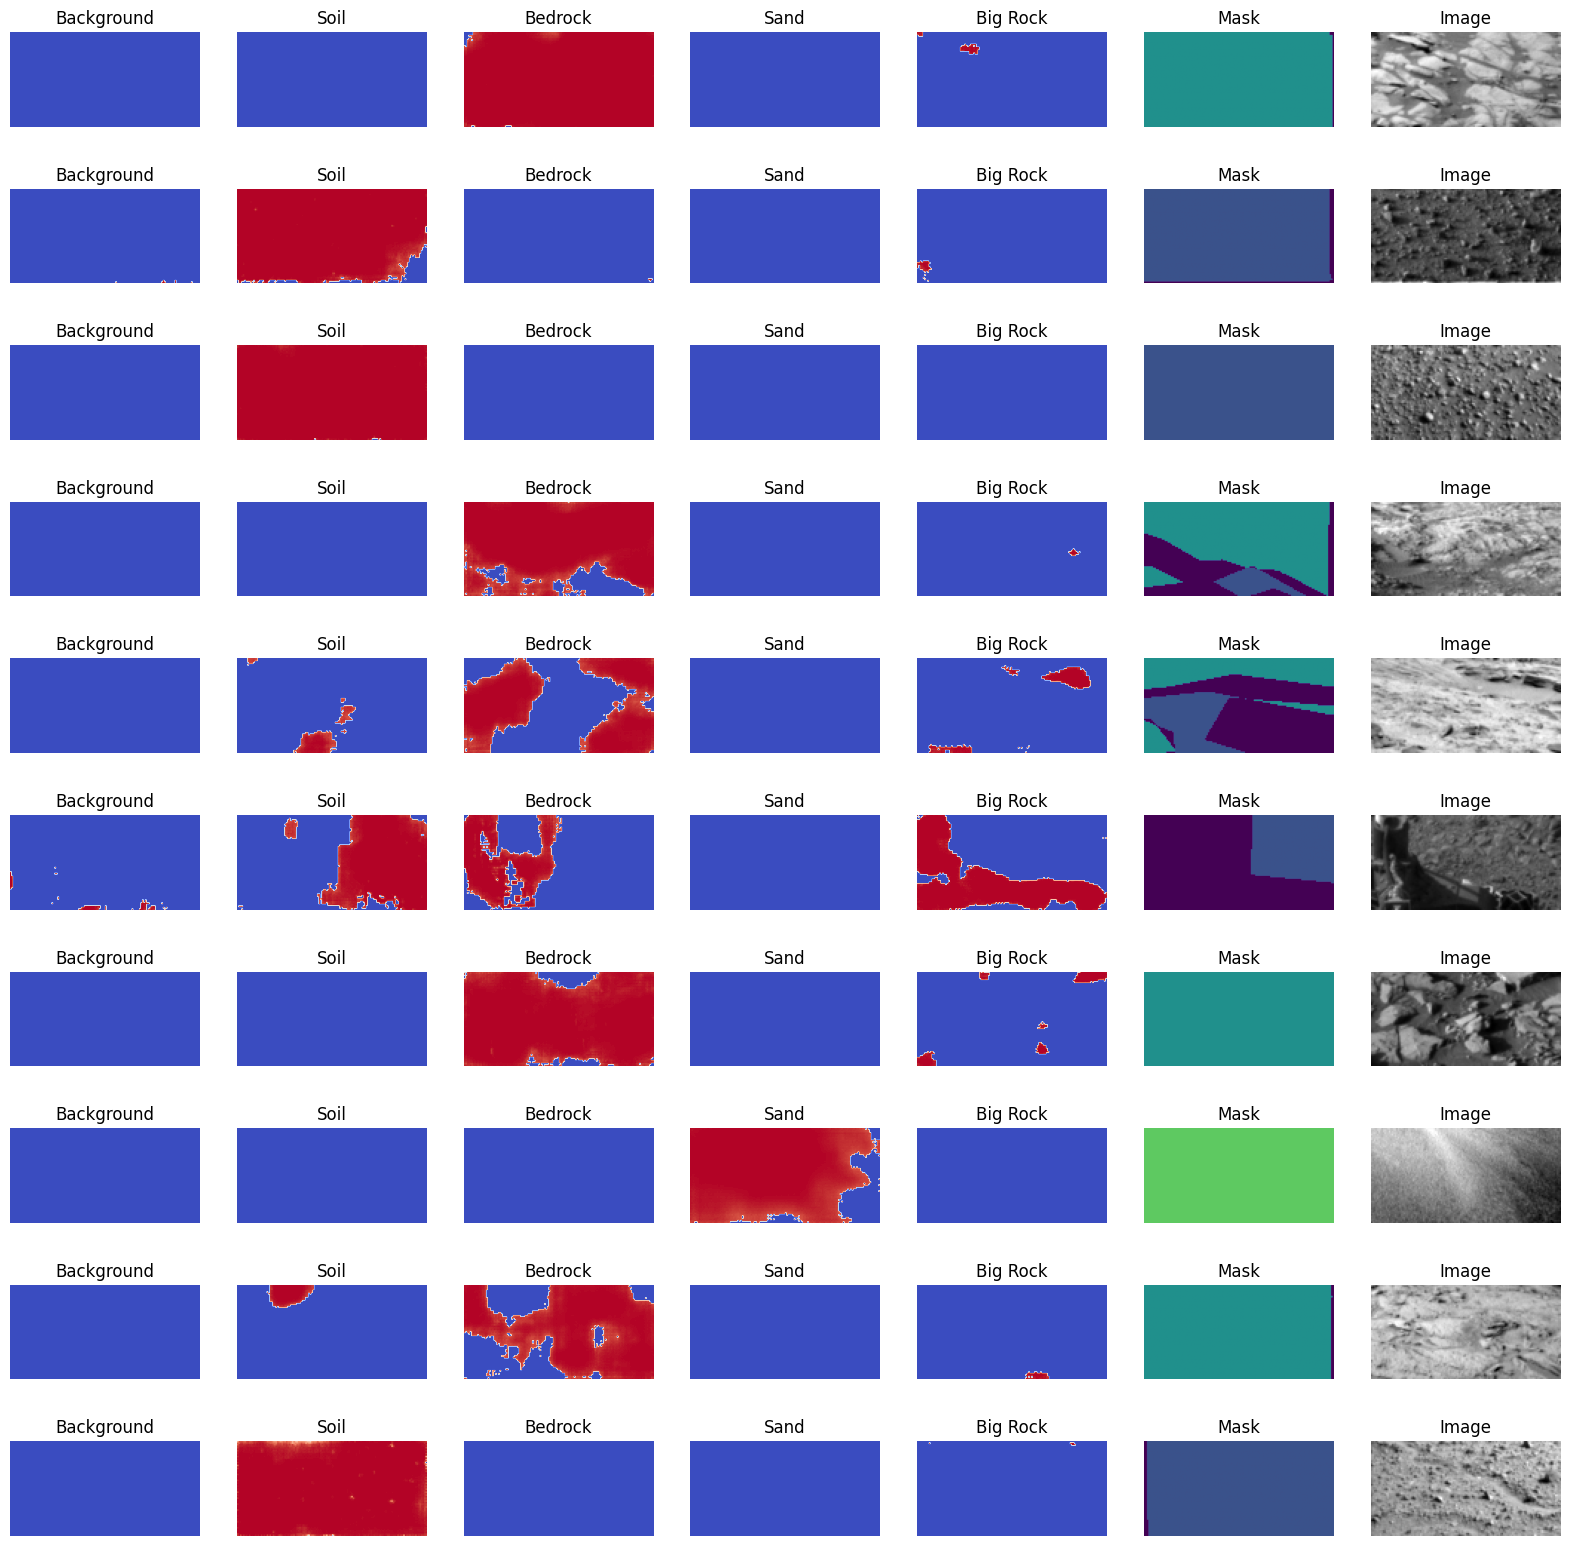

In [33]:
plot_probabilities(
    X_val,
    y_val,
    combined_val_predictions,
    big_rock_probas,
    combined_threshold=0.90,
    big_rock_threshold=0.95,
)

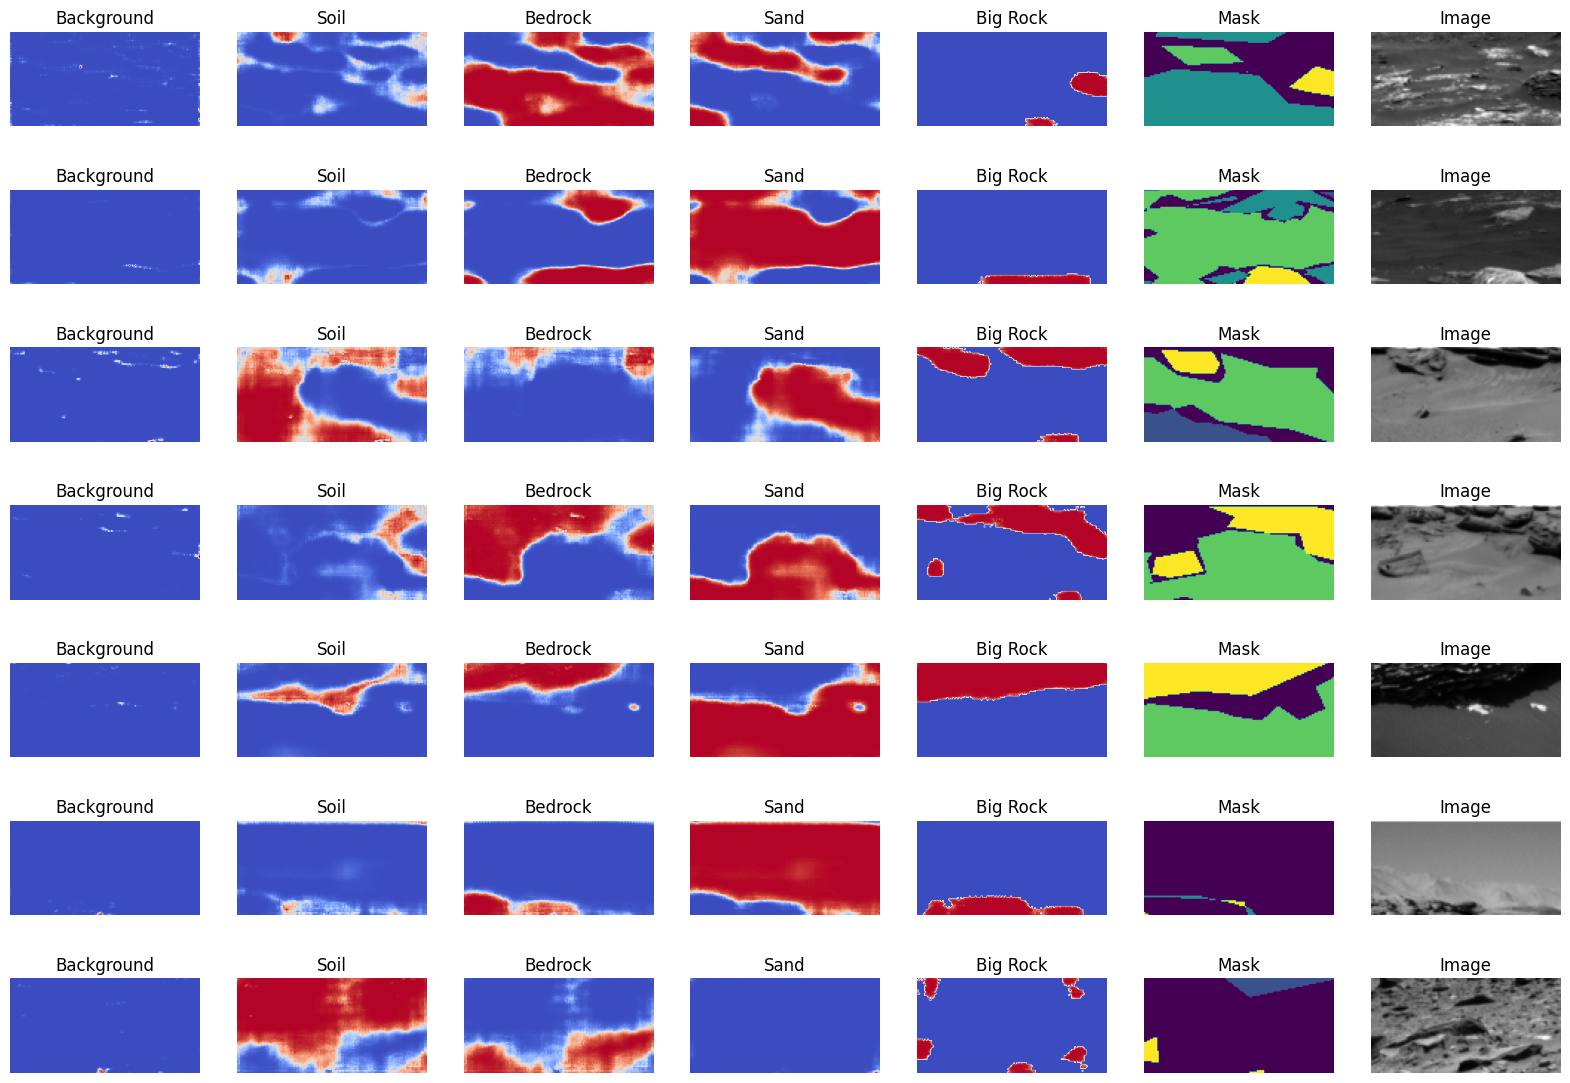

In [34]:
plot_probabilities(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    combined_val_predictions[big_rock_mask],
    big_rock_probas[big_rock_mask],
    n=big_rock_mask.sum(),
    combined_threshold=0.00,
    big_rock_threshold=0.75,
)

### Test Time Augmentation

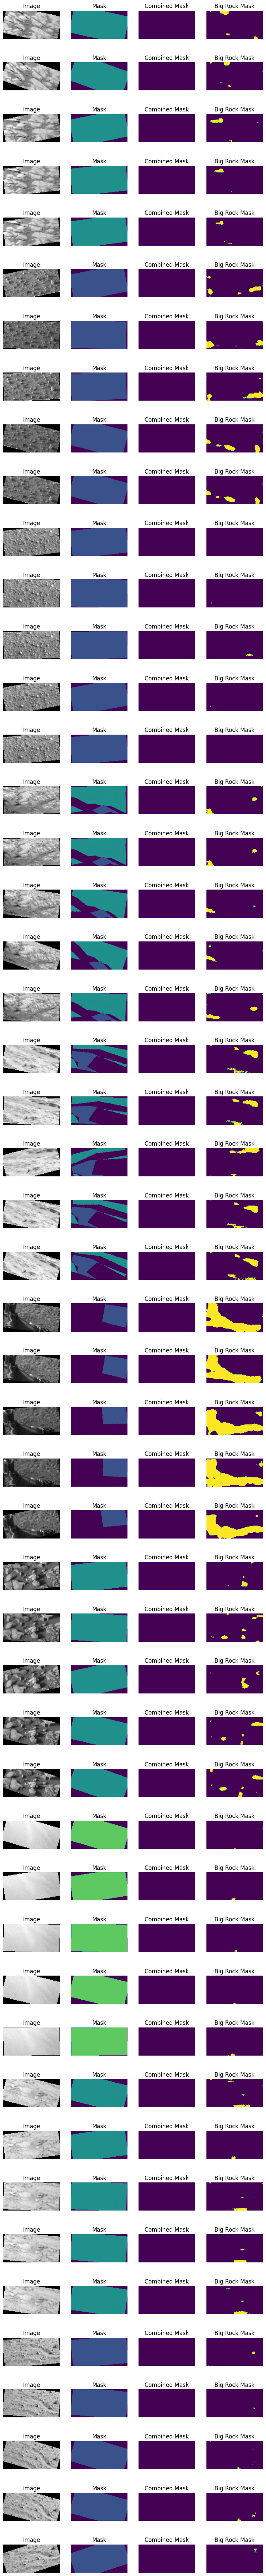

In [35]:
plot_predictions(
    X_augmented,
    y_augmented,
    np.zeros_like(big_rock_augmented_argmax),
    big_rock_augmented_argmax,
    n=50,
)

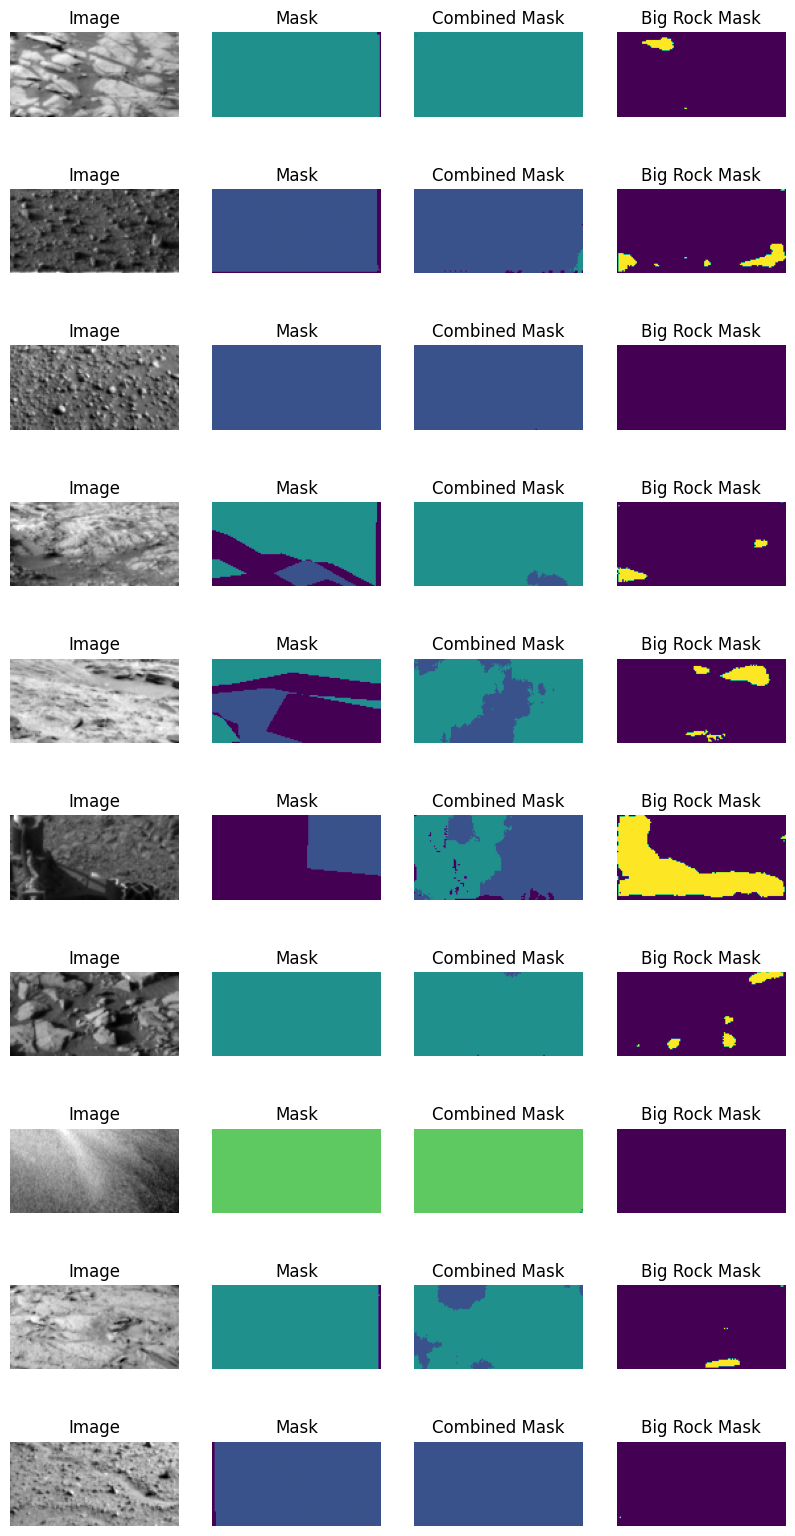

In [36]:
plot_predictions(
    X_val,
    y_val,
    combined_val_argmax,
    big_rock_augmented_batch_argmax,
)

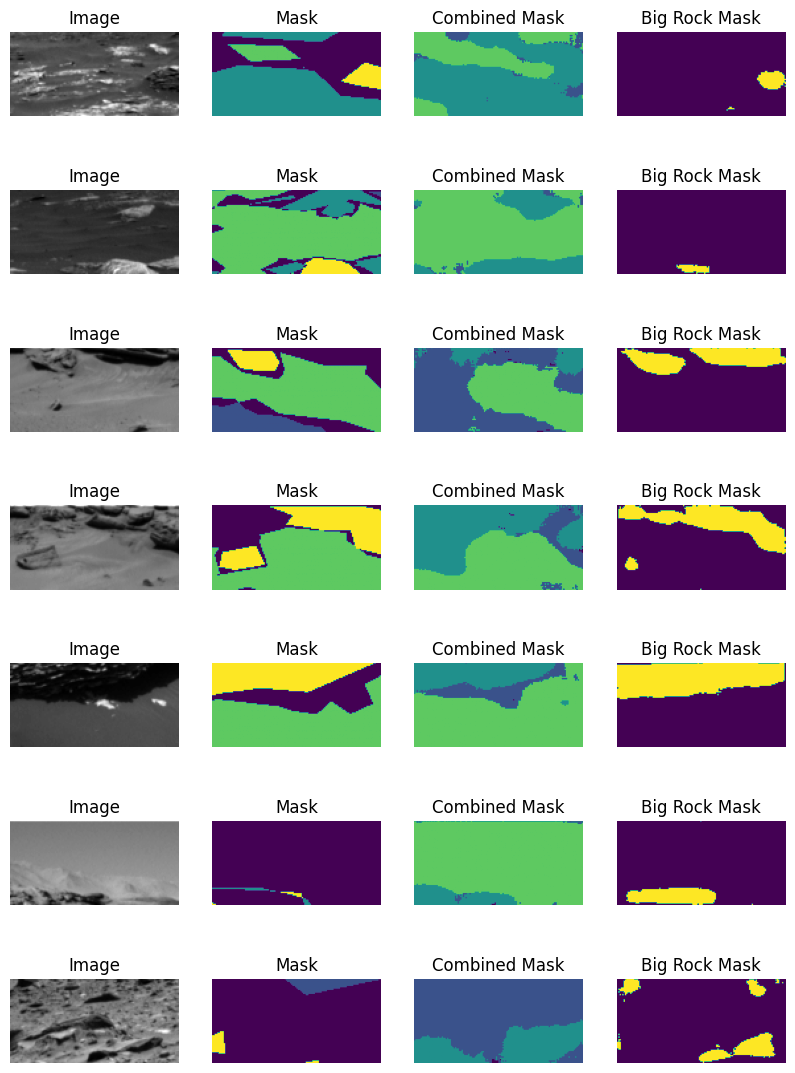

In [37]:
plot_predictions(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    combined_val_argmax[big_rock_mask],
    big_rock_augmented_batch_argmax[big_rock_mask],
    n=big_rock_mask.sum(),
)

## Aggregate predictions

In [38]:
baseline = mean_iou(y_val, combined_val_argmax)
baseline

0.49003142

In [39]:
def evaluate_aggregation(agg_fn, mask, combined, big_rock) -> np.ndarray:
    final = agg_fn(combined, big_rock)
    plot_predictions(X_val, y_val, final, np.zeros_like(final))
    aggregated_mean_iou = mean_iou(mask, final)
    print(f"Aggregated mean IoU {aggregated_mean_iou} ", end="")
    if aggregated_mean_iou <= baseline:
        print("is lower than baseline")
    else:
        print("is higher than baseline")
    return final

### Always replace with big rock

Aggregated mean IoU 0.48266926407814026 is lower than baseline


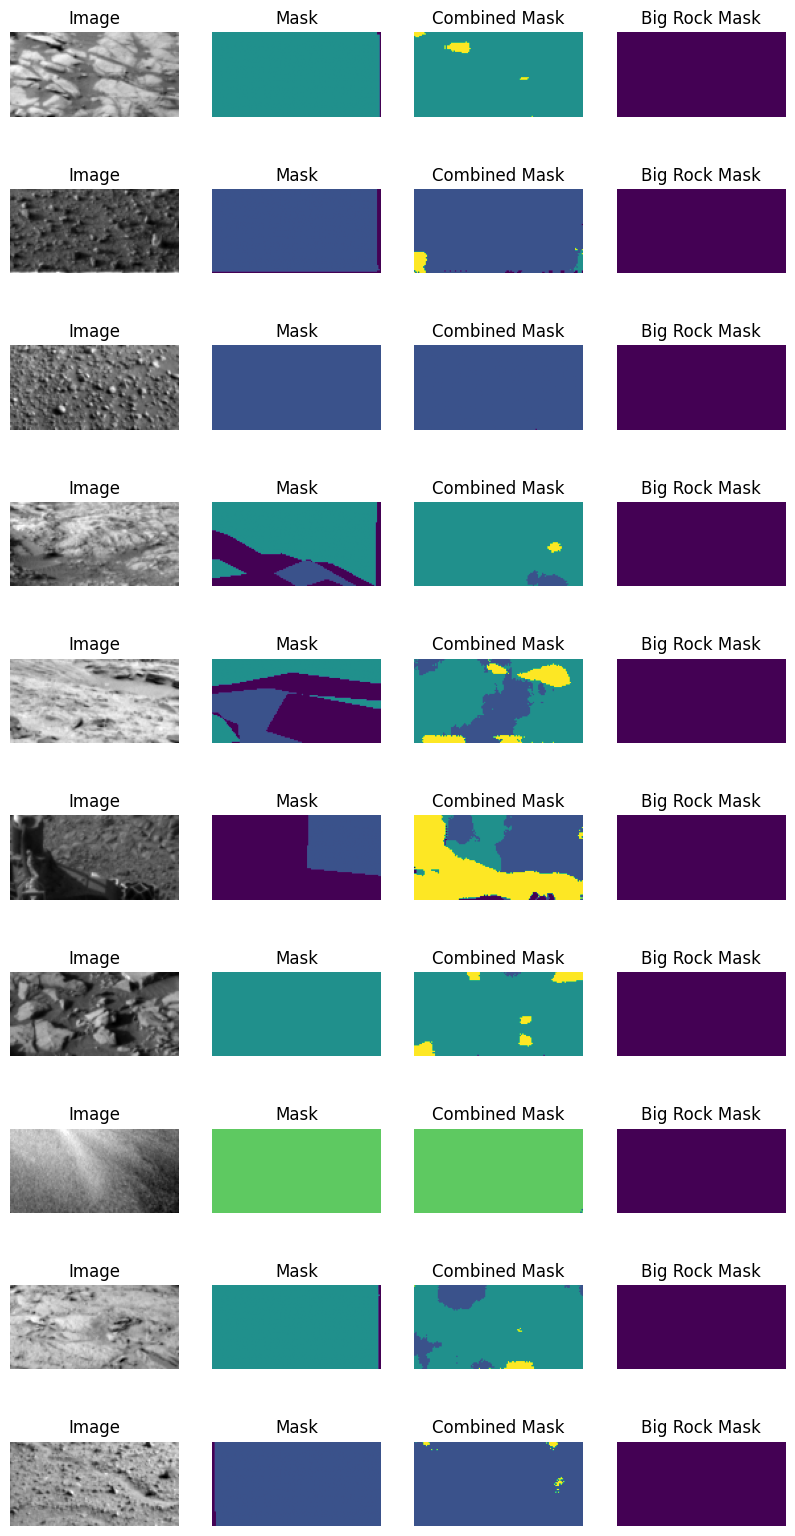

In [40]:
_ = evaluate_aggregation(
    lambda combined, big_rock: np.where(big_rock == 4, big_rock, combined),
    y_val,
    combined_val_argmax,
    big_rock_val_argmax,
)

Aggregated mean IoU 0.48127681016921997 is lower than baseline


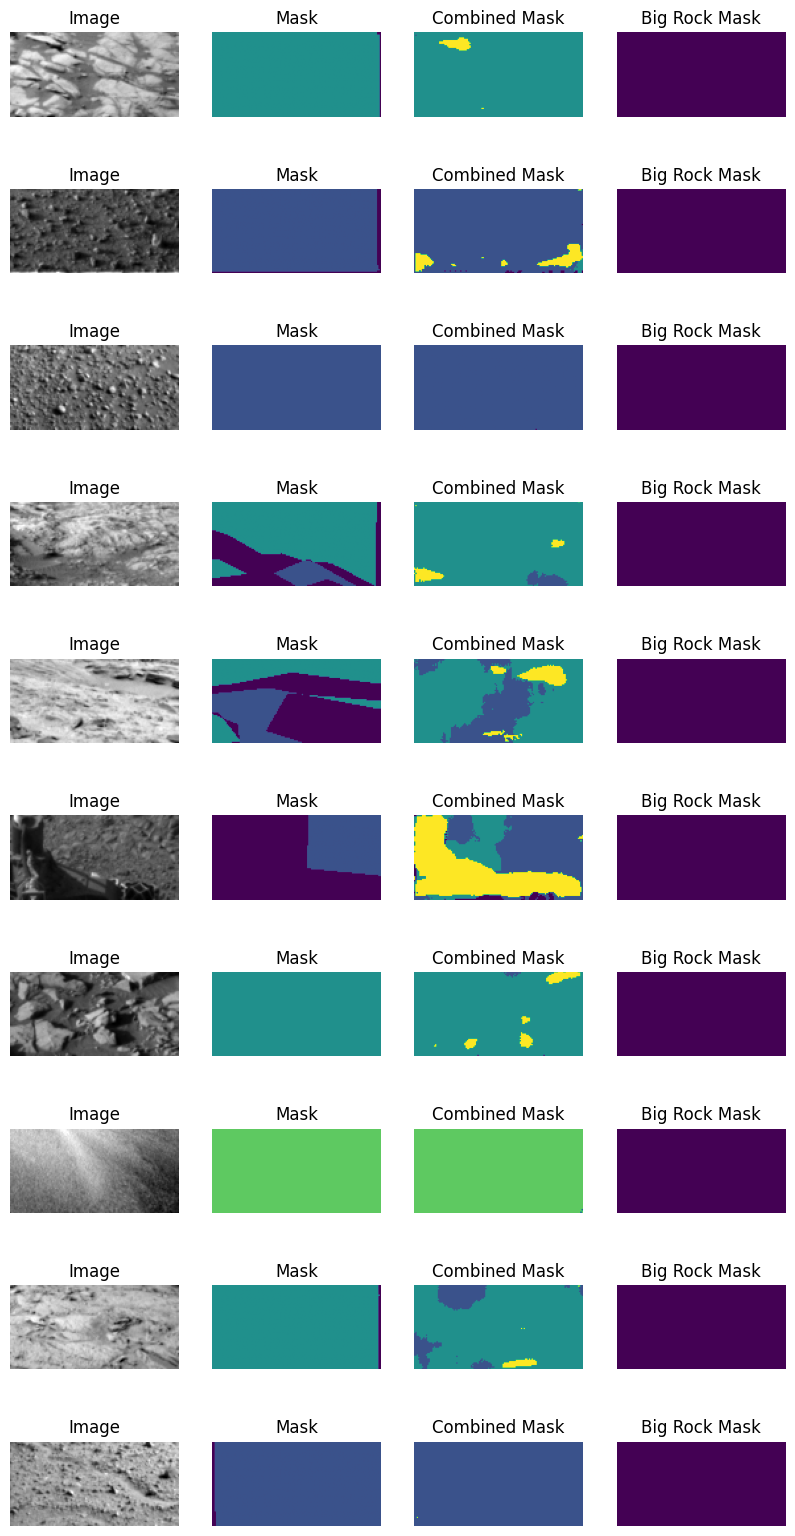

In [41]:
_ = evaluate_aggregation(
    lambda combined, big_rock: np.where(big_rock == 4, big_rock, combined),
    y_val,
    combined_val_argmax,
    big_rock_augmented_batch_argmax,
)

### Always replace background with big rock

Aggregated mean IoU 0.49034109711647034 is higher than baseline


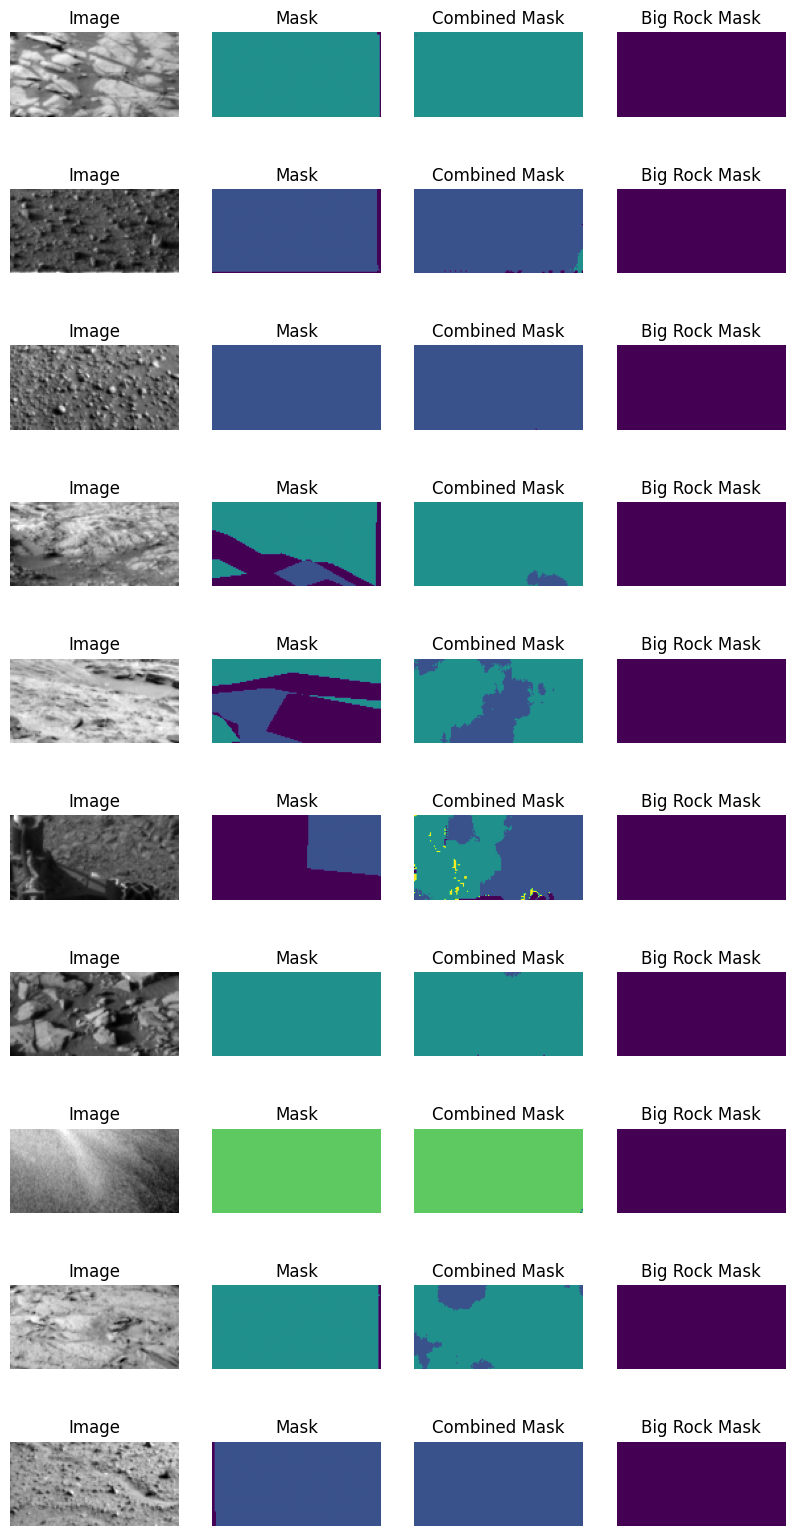

In [42]:
def replace_background(combined, big_rock) -> np.ndarray:
    return np.where(combined == 0, big_rock, combined)


_ = evaluate_aggregation(
    replace_background,
    y_val,
    combined_val_argmax,
    big_rock_val_argmax,
)

Aggregated mean IoU 0.49032720923423767 is higher than baseline


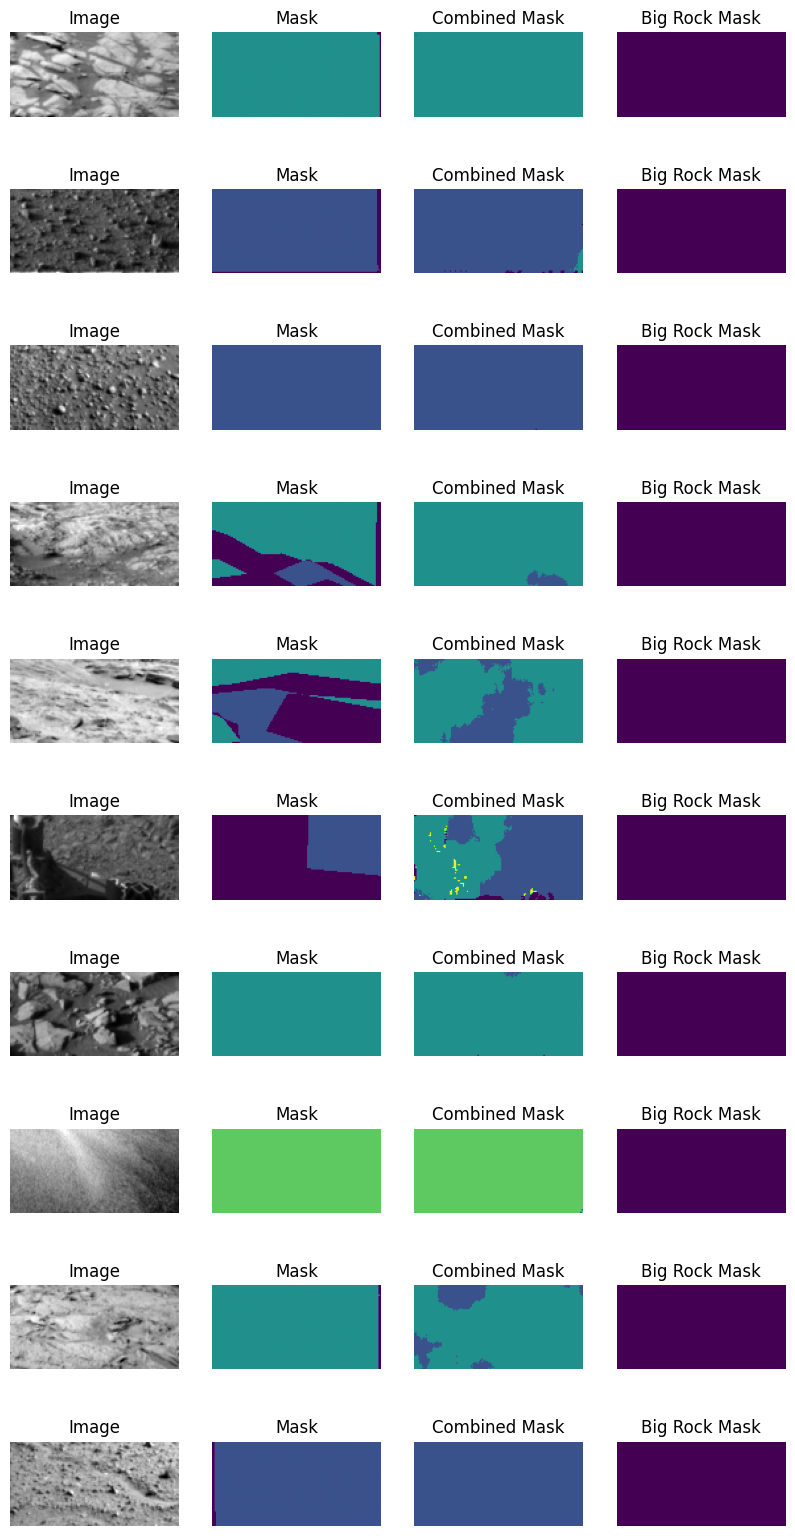

In [43]:
_ = evaluate_aggregation(
    replace_background,
    y_val,
    combined_val_argmax,
    big_rock_augmented_batch_argmax,
)

### Replace given threshold

In [44]:
def weighted_threshold_merge(
    combined,
    big_rock,
    always_replace_background=False,
    combined_threshold=0.99,
    big_rock_threshold=0.99,
    big_rock_weight=0.5,
) -> np.ndarray:
    optimisation_combined_prediction = combined[:, :, :, :4]
    optimisation_combined_prediction = np.where(
        optimisation_combined_prediction > combined_threshold,
        optimisation_combined_prediction,
        0.0,
    )

    optimisation_big_rock_prediction = np.where(
        big_rock > big_rock_threshold,
        big_rock,
        0.0,
    )

    optimisation_prediction = np.concatenate(
        [
            (1 - big_rock_weight) * optimisation_combined_prediction,
            big_rock_weight * optimisation_big_rock_prediction,
        ],
        axis=-1,
    )
    optimisation_prediction = np.argmax(optimisation_prediction, axis=-1)
    if always_replace_background:
        optimisation_prediction = np.where(
            np.logical_and(
                optimisation_prediction == 0,
                (optimisation_big_rock_prediction > 0.5).squeeze(),
            ),
            4,
            optimisation_prediction,
        )

    return optimisation_prediction


In [45]:
def optimize(trial: optuna.Trial) -> float:
    always_replace_background = trial.suggest_categorical(
        "always_replace_background", [True, False]
    )
    big_rock_weight = trial.suggest_float("big_rock_weight", 0.1, 0.8)
    big_rock_threshold = trial.suggest_float("big_rock_threshold", 0.5, 0.99)
    combined_threshold = trial.suggest_float("combined_threshold", 0.0, 1.0)

    number_samples = combined_val_predictions.shape[0]

    mean_iou_list = []
    for _ in range(10):
        i = RNG.choice(number_samples, number_samples, replace=True)
        fold_predictions = weighted_threshold_merge(
            combined_val_predictions[i],
            big_rock_probas[i],
            always_replace_background=always_replace_background,
            combined_threshold=combined_threshold,
            big_rock_threshold=big_rock_threshold,
            big_rock_weight=big_rock_weight,
        )

        # Calculate the accuracy score
        mean_iou_list.append(mean_iou(y_val[i], fold_predictions))

    return np.mean(mean_iou_list)


sampler = optuna.samplers.TPESampler(
    n_startup_trials=50,
    multivariate=True,
    seed=SEED,
)

study = optuna.create_study(
    sampler=sampler,
    direction="maximize",
)
study.optimize(
    optimize,
    n_trials=1000,
    show_progress_bar=True,
    n_jobs=-1,
)

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-12-14 09:26:11,225] A new study created in memory with name: no-name-7b1d2ce9-2bd4-4909-b8e0-9c80b0935867


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-12-14 09:26:22,115] Trial 0 finished with value: 0.5036756992340088 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.44470006282075925, 'big_rock_threshold': 0.8718307712322997, 'combined_threshold': 0.21011250783824997}. Best is trial 0 with value: 0.5036756992340088.
[I 2024-12-14 09:26:22,137] Trial 15 finished with value: 0.4955297112464905 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2200345125200751, 'big_rock_threshold': 0.8225464626108383, 'combined_threshold': 0.7825744269178472}. Best is trial 0 with value: 0.5036756992340088.
[I 2024-12-14 09:26:22,142] Trial 13 finished with value: 0.4916219711303711 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.10965455171003569, 'big_rock_threshold': 0.6659244770590134, 'combined_threshold': 0.2560601029066518}. Best is trial 0 with value: 0.5036756992340088.
[I 2024-12-14 09:26:22,172] Trial 10 finished with value: 0.4781305193901062 and parameters:

In [46]:
print(study.best_params)
print(f"Best mean IoU: {study.best_value}")

{'always_replace_background': False, 'big_rock_weight': 0.46604148649061455, 'big_rock_threshold': 0.7002490978098769, 'combined_threshold': 0.07720113025222375}
Best mean IoU: 0.5140249133110046


<Axes: >

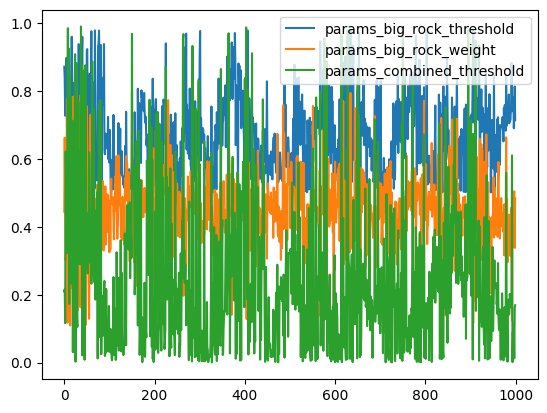

In [47]:
study.trials_dataframe().filter(like="params").plot()

Aggregated mean IoU 0.5074945688247681 is higher than baseline


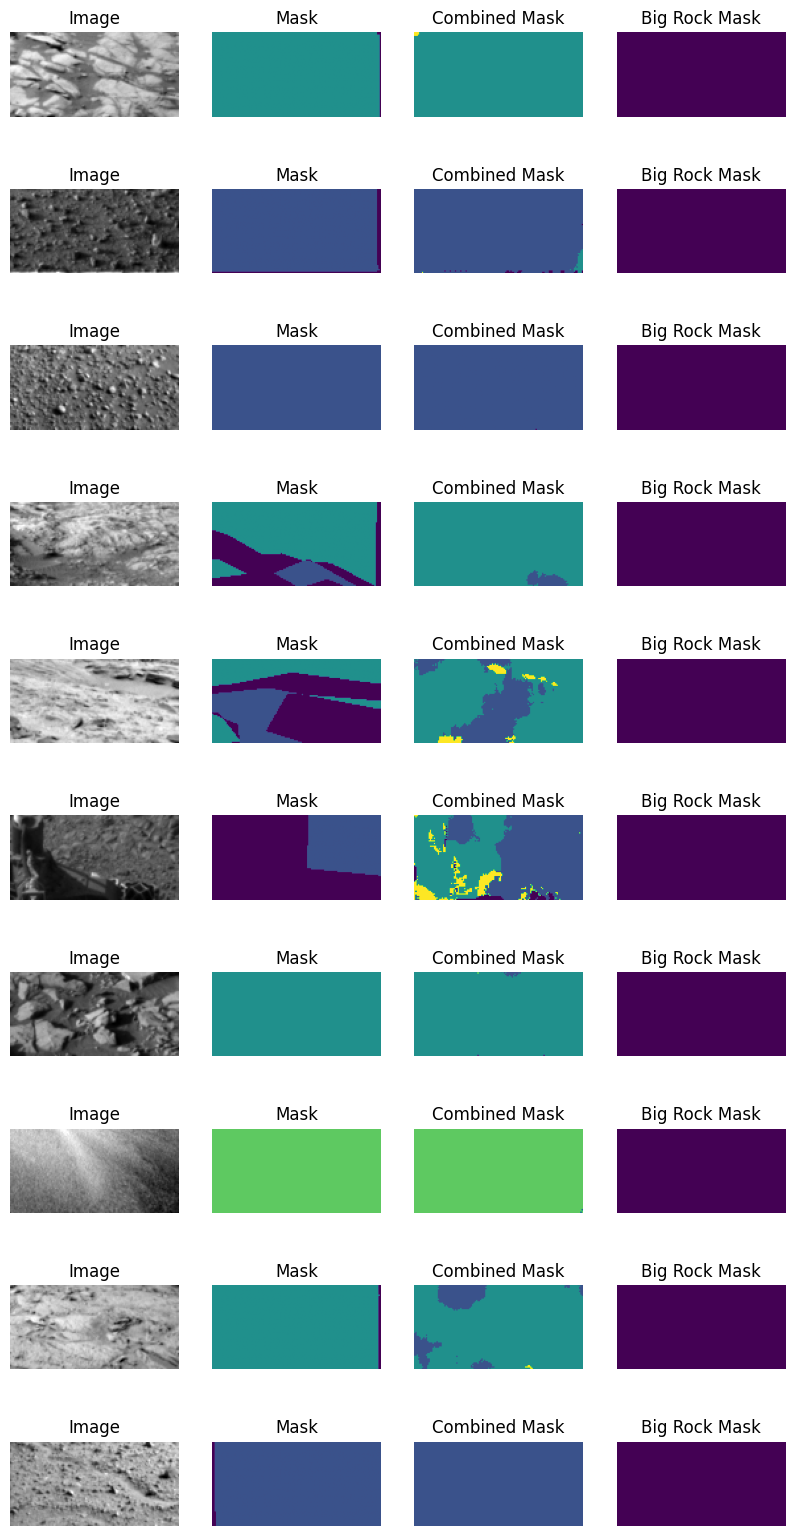

In [48]:
_ = evaluate_aggregation(
    partial(weighted_threshold_merge, **study.best_params),
    y_val,
    combined_val_predictions,
    big_rock_probas,
)

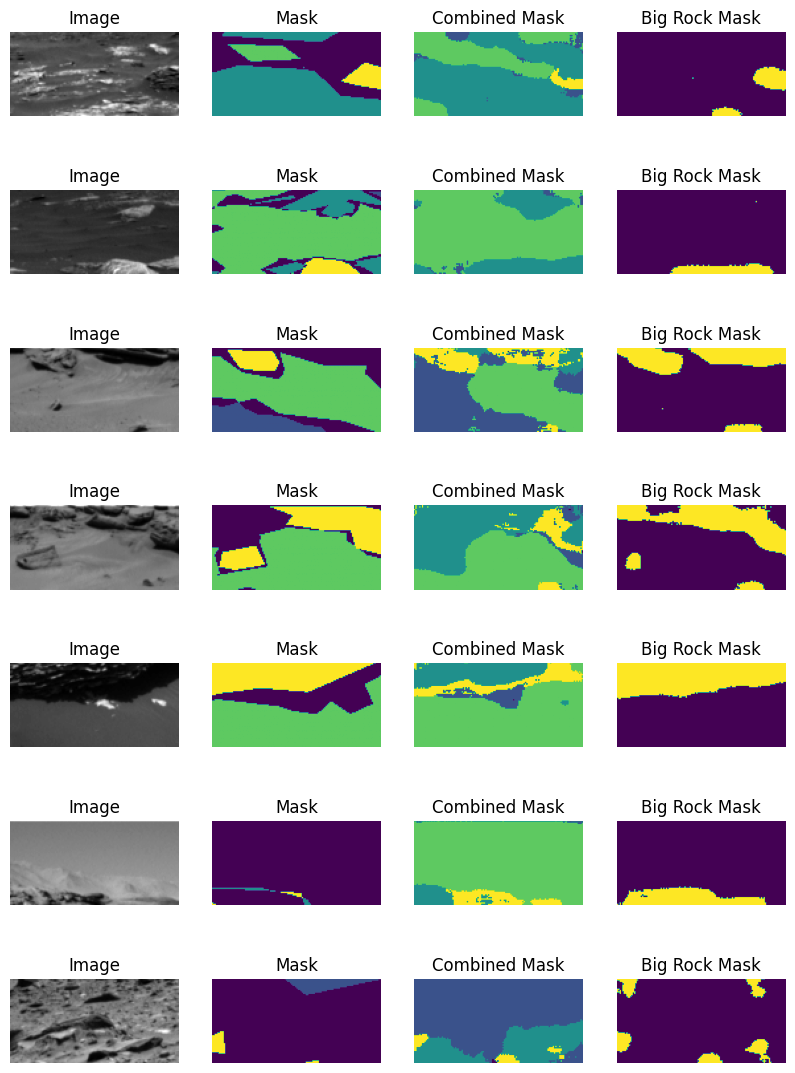

In [49]:
weighted_threshold_argmax = weighted_threshold_merge(
    combined_val_predictions, big_rock_probas, **study.best_params
)
plot_predictions(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    weighted_threshold_argmax[big_rock_mask],
    big_rock_val_argmax[big_rock_mask],
    n=big_rock_mask.sum(),
)

## Compute submission

In [50]:
combined_test_predictions = combined_model.predict(X_test)
big_rock_test_predictions = big_rock_model.predict(X_test)

314/314 ━━━━━━━━━━━━━━━━━━━━ 219s 696ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 209s 666ms/step


In [51]:
optimisation_test_argmax = weighted_threshold_merge(
    combined_test_predictions,
    big_rock_test_predictions[:, :, :, 1][..., np.newaxis],
    **study.best_params,
)

In [52]:
print(optimisation_test_argmax.shape)
print(np.unique(optimisation_test_argmax))

(10022, 64, 128)
[0 1 2 3 4]


In [53]:
predicted_masks = optimisation_test_argmax

In [54]:
predicted_masks = replace_background(
    np.argmax(combined_test_predictions, axis=-1),
    np.argmax(big_rock_test_predictions, axis=-1),
)

In [55]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [56]:
# Create and download the csv submission file
submission_filename = "submission.csv"
submission_df = y_to_df(predicted_masks)
submission_df.to_csv(submission_filename, index=False)